# Monitor testing and debugging as it goes

In [547]:
import os
import sys
import time
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# # rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation

import pickle

%matplotlib inline

import re
numeric_const_pattern = r"""
     [-+]? 
     (?:
         (?: \d* \. \d+ )
         |
         (?: \d+ \.? )
     )
     (?: [Ee] [+-]? \d+ ) ?
     """
rx = re.compile(numeric_const_pattern, re.VERBOSE)

from IPython.display import clear_output
from IPython.display import Video

from scipy.stats.stats import pearsonr

print(sns.__version__)

0.11.2


<ipython-input-547-f0dd16ca9837>:42: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [122]:
def add_patch(legend, n=1):
    from matplotlib.patches import Patch
    ax = legend.axes

    handles, labels = ax.get_legend_handles_labels()
    for i in range(n):
        handles.append(Patch(facecolor='white', edgecolor='white', alpha=0.1))
        labels.append(" ")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())

In [38]:
fig_dir = '../fig/'
output_dir = '../out'
datapath = '../data/data_poisson_10'
T=1000
cf_radius = 0.0
# opts = '1-2-3-4-6'
opts = '1-3-4-6'
# pburst = 0.0
pburst = 0.5
# opts = [int(i) for i in opts]
# opts_txt = [str(i) for i in opts]
# opts_txt = '-'.join(opts_txt)
link_rate_max = 42  # 42
link_rate_min = 10  # 10
link_rate_avg = (link_rate_max + link_rate_min)/2
csvfile = 'test_data_poisson_10_ir_0.0_opts_{}_link_26.0_pb_{}_ls_1.0_lb_1.0_robust_False_T_1000_TV_1000.csv'.format(
    opts, pburst,
)
# output_csv = os.path.join(output_dir, "test_{}_T_{}_ir_{:.1f}_opts_{}_link-{}_antbpanthoc_burstymobility_multigraph_result.csv".format(
#     datapath.split("/")[-1], T, cf_radius, opts_txt , link_rate_avg))
csvfull = os.path.join(output_dir, csvfile)
print(csvfull)

../out/test_data_poisson_10_ir_0.0_opts_1-3-4-6_link_26.0_pb_0.5_ls_1.0_lb_1.0_robust_False_T_1000_TV_1000.csv


In [39]:
df.columns

Index(['filename', 'seed', 'num_nodes', 'm', 'T', 'cf_radius', 'cf_degree',
       'opt', 'Algo', 'num_flows', 'physical', 'z', 'src_delay_raw',
       'src_jitter_raw', 'delivery_raw', 'active_links', 'runtime', 'function',
       'exploration_rate', 'decay_rate', 'unit', 'not_going_back', 'f_case',
       'cnt_out_raw', 'cnt_in_raw', 'flow_rate', 'cutoff', 'src', 'dst',
       'ph_diff'],
      dtype='object')

In [52]:
df = pd.read_csv(csvfull)

In [53]:
df_gp = df.groupby(["filename", "physical", "f_case", "cutoff", "Algo"]).mean()

## Mixed traffic

In [54]:
df_gp.loc[:,["src_delay_raw", "src_jitter_raw", "delivery_raw", "runtime"]] 

src_delay_raw  \
filename                              physical f_case cutoff Algo                           
poisson_graph_seed500_m8_n100_f17.mat 0        0      -1     Ant-BP-mirror       4.487810   
                                                       30    Ant-BP-mirror       5.078469   
                                      1        0      -1     Ant-BP              3.097733   
                                                             Ant-BP-mirror       3.117118   
                                                             Ant-Baseline       12.735864   
                                                             SP-BP               4.271512   
                                                       30    Ant-BP              4.294899   
                                                             Ant-BP-mirror       3.508908   
                                                             Ant-Baseline       32.583032   
                                                             SP-BP               5.078469   

                                                                            src_jitter_raw  \
filename                              physical f_case cutoff Algo                            
poisson_graph_seed500_m8_n100_f17.mat 0        0      -1     Ant-BP-mirror       23.970540   
                                                       30    Ant-BP-mirror       51.437007   
                                      1        0      -1     Ant-BP              18.377006   
                                                             Ant-BP-mirror       34.068261   
                                                             Ant-Baseline       734.858141   
                                                             SP-BP               19.276221   
                                                       30    Ant-BP              28.398759   
                                                             Ant-BP-mirror       25.220041   
                                                             Ant-Baseline      7937.842116   
                                                             SP-BP               51.437007   

                                                                            delivery_raw  \
filename                              physical f_case cutoff Algo                          
poisson_graph_seed500_m8_n100_f17.mat 0        0      -1     Ant-BP-mirror      0.991671   
                                                       30    Ant-BP-mirror      1.000000   
                                      1        0      -1     Ant-BP             0.996594   
                                                             Ant-BP-mirror      0.997597   
                                                             Ant-Baseline       0.984832   
                                                             SP-BP              0.996634   
                                                       30    Ant-BP             1.000000   
                                                             Ant-BP-mirror      1.000000   
                                                             Ant-Baseline       0.991897   
                                                             SP-BP              1.000000   

                                                                               runtime  
filename                              physical f_case cutoff Algo                       
poisson_graph_seed500_m8_n100_f17.mat 0        0      -1     Ant-BP-mirror   53.240175  
                                                       30    Ant-BP-mirror   53.240175  
                                      1        0      -1     Ant-BP          97.514217  
                                                             Ant-BP-mirror  102.468062  
                                                             Ant-Baseline   114.458604  
                                                             SP-BP          101.929998  
             

## streaming

Ant-coldstart performs so bad that we don't run it in our full test

In [37]:
df_gp.loc[:,["src_delay_raw", "src_jitter_raw", "delivery_raw", "runtime"]] 

src_delay_raw  \
filename                              physical f_case cutoff Algo                           
poisson_graph_seed500_m8_n100_f17.mat 0        0.0    -1.0   Ant-BP              4.749311   
                                                             Ant-Baseline       22.286536   
                                      1        0.0    -1.0   Ant-BP              4.388882   
                                                             Ant-BP-mirror       4.388882   
                                                             Ant-Baseline       22.024212   
                                                             Ant-coldstart     297.431699   

                                                                            src_jitter_raw  \
filename                              physical f_case cutoff Algo                            
poisson_graph_seed500_m8_n100_f17.mat 0        0.0    -1.0   Ant-BP              32.983682   
                                                             Ant-Baseline      2306.978861   
                                      1        0.0    -1.0   Ant-BP              85.742183   
                                                             Ant-BP-mirror       85.742183   
                                                             Ant-Baseline      2150.401957   
                                                             Ant-coldstart    50258.641668   

                                                                            delivery_raw  \
filename                              physical f_case cutoff Algo                          
poisson_graph_seed500_m8_n100_f17.mat 0        0.0    -1.0   Ant-BP             0.991470   
                                                             Ant-Baseline       0.970487   
                                      1        0.0    -1.0   Ant-BP             0.995687   
                                                             Ant-BP-mirror      0.995687   
                                                             Ant-Baseline       0.975316   
                                                             Ant-coldstart      0.146685   

                                                                               runtime  
filename                              physical f_case cutoff Algo                       
poisson_graph_seed500_m8_n100_f17.mat 0        0.0    -1.0   Ant-BP          69.231945  
                                                             Ant-Baseline   214.400885  
                                      1        0.0    -1.0   Ant-BP         187.047372  
                                                             Ant-BP-mirror  177.006021  
                                                             Ant-Baseline   205.652352  
                                                             Ant-coldstart  537.782635

# Read server results

In [449]:
# Just one time run to rename schemes 3 and 4 with settings of TV=500 
fig_dir = '../fig/'
output_dir = '../out'
datapath = '../data/data_poisson_10'
T=1000
TV=1000
cf_radius = 0.0
pburst = 0.5
link_rate_max = 42  # 42
link_rate_min = 10  # 10
link_rate_avg = (link_rate_max + link_rate_min)/2

df_res = pd.DataFrame([])
for opt in [1]:
#     for lb in [0.5, 2.0, 1.0, 3.0, 5.0, 7.0, 9.0, 10.0]:
    for lb in [0.5, 2.0]:
        csvfile = 'test_data_poisson_10_ir_0.0_opts_{}_link_26.0_pb_{}_ls_1.0_lb_{:.1f}_robust_False_T_1000_TV_{}.csv'.format(
            opt, pburst, lb, TV
        )
        csvfull = os.path.join(output_dir, csvfile)
        print(csvfull)
        newfull = os.path.join('../out_backup', csvfile)
#         newfull = os.path.join(
#             '../out_backup', 
#             'test_data_poisson_10_ir_0.0_opts_{}_link_26.0_pb_{}_ls_1.0_lb_{:.1f}_robust_False_T_1000_TV_{}.csv'.format(
#                 opt, pburst, lb, TV
#             )
#         )
        if os.path.isfile(newfull):
            print("Already exist: {}".format(newfull))
        else:
            print("renamed as {}".format(newfull))
            os.rename(csvfull, newfull)
#         df_tmp = pd.read_csv(csvfull, index_col=False)
#         df_tmp['lb'] = lb
#         df_res = pd.concat([df_res, df_tmp], ignore_index=True)
#     df_res.to_csv(output_csv, index=False)



../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_1.0_lb_0.5_robust_False_T_1000_TV_1000.csv
Already exist: ../out_backup/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_1.0_lb_0.5_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_1.0_lb_2.0_robust_False_T_1000_TV_1000.csv
Already exist: ../out_backup/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_1.0_lb_2.0_robust_False_T_1000_TV_1000.csv


In [516]:
fig_dir = '../fig/'
output_dir = '../out'
datapath = '../data/data_poisson_10'
T=1000
TV=1000
cf_radius = 0.0
pburst = 0.5
link_rate_max = 42  # 42
link_rate_min = 10  # 10
link_rate_avg = (link_rate_max + link_rate_min)/2

df_res = pd.DataFrame([])
for opt in [1,3,4,6,5]:
    if opt==5:
        htxt = 'h_sum_'
    else:
        htxt = ''

    for lb in [0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 9.0, 10.0]:
        csvfile = 'test_data_poisson_10_ir_0.0_opts_{}_{}link_26.0_pb_{}_ls_1.0_lb_{:.1f}_robust_False_T_1000_TV_{}.csv'.format(
            opt, htxt, pburst, lb, TV
        )
        csvfull = os.path.join(output_dir, csvfile)
        if os.path.isfile(csvfull):
            print(csvfull)
        else:
            print("skip: {}".format(csvfull))
            continue
        df_tmp = pd.read_csv(csvfull, index_col=False)
        df_tmp['lb'] = lb
        df_res = pd.concat([df_res, df_tmp], ignore_index=True)
#     df_res.to_csv(output_csv, index=False)

df_res['delay_synth'] = df_res['delivery_raw']*df_res['src_delay_raw'] + (1- df_res['delivery_raw'])*1000#df_res['T']
# def_res.rename(columns={'lb': 'X', 'b': 'Y'}) 
condition = ((df_res['cutoff'] == -1) & (df_res['physical'] == 1))
df_res.loc[condition, 'Flow'] = 'streaming'
condition = ((df_res['cutoff'] == 30) & (df_res['physical'] == 1))
df_res.loc[condition, 'Flow'] = 'bursty'
df_res.shape

../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_1.0_lb_0.5_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_1.0_lb_1.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_1.0_lb_2.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_1.0_lb_3.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_1.0_lb_5.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_1.0_lb_7.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_1.0_lb_9.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_1.0_lb_10.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.5_ls_1.0_lb_0.5_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb

(247171, 33)

In [517]:
# Check test progress  by counting how many results are there
df_res[df_res['physical'] == 1].groupby(["Algo", "lb"]).count()

filename  seed  num_nodes     m     T  cf_radius  \
Algo          lb                                                       
Ant-BP        0.5       3919  3919       3919  3919  3919       3919   
              1.0       3919  3919       3919  3919  3919       3919   
              2.0       3919  3919       3919  3919  3919       3919   
              3.0       3919  3919       3919  3919  3919       3919   
              5.0       3919  3919       3919  3919  3919       3919   
              7.0       3919  3919       3919  3919  3919       3919   
              9.0       3919  3919       3919  3919  3919       3919   
              10.0      3919  3919       3919  3919  3919       3919   
Ant-BP-mirror 0.5       3919  3919       3919  3919  3919       3919   
              1.0       3919  3919       3919  3919  3919       3919   
              2.0       3919  3919       3919  3919  3919       3919   
              3.0       3919  3919       3919  3919  3919       3919   
              5.0       3919  3919       3919  3919  3919       3919   
              7.0       3919  3919       3919  3919  3919       3919   
              9.0       3919  3919       3919  3919  3919       3919   
              10.0      3919  3919       3919  3919  3919       3919   
Ant-Baseline  0.5       3919  3919       3919  3919  3919       3919   
              1.0       3919  3919       3919  3919  3919       3919   
              2.0       3919  3919       3919  3919  3919       3919   
              3.0       3919  3919       3919  3919  3919       3919   
              5.0       3919  3919       3919  3919  3919       3919   
              7.0       3919  3919       3919  3919  3919       3919   
              9.0       3919  3919       3919  3919  3919       3919   
              10.0      3919  3919       3919  3919  3919       3919   
Ant-ideal     0.5       3919  3919       3919  3919  3919       3919   
              1.0       3919  3919       3919  3919  3919       3919   
              2.0       3919  3919       3919  3919  3919       3919   
              3.0       3919  3919       3919  3919  3919       3919   
              5.0       3919  3919       3919  3919  3919       3919   
              7.0       3919  3919       3919  3919  3919       3919   
              9.0       3919  3919       3919  3919  3919       3919   
              10.0      3919  3919       3919  3919  3919       3919   
SP-BP         0.5       3919  3919       3919  3919  3919       3919   
              1.0       3919  3919       3919  3919  3919       3919   
              2.0       3919  3919       3919  3919  3919       3919   
              3.0       3919  3919       3919  3919  3919       3919   
              5.0       3919  3919       3919  3919  3919       3919   
              7.0       3919  3919       3919  3919  3919       3919   
              9.0       3919  3919       3919  3919  3919       3919   
              10.0      3919  3919       3919  3919  3919       3919   

                    cf_degree  f_case  num_flows  flow_rate  ...     z  \
Algo          lb                                             ...         
Ant-BP        0.5        3919    3919       3919       3919  ...  3919   
              1.0        3919    3919       3919       3919  ...  3919   
              2.0        3919    3919       3919       3919  ...  3919   
              3.0        3919    3919       3919       3919  ...  3919   
              5.0        3919    3919       3919       3919  ...  3919   
              7.0        3919    3919       3919       3919  ...  3919   
              9.0        3919    3919       3919       3919  ...  3919   
              10.0       3919    3919       3919       3919  ...  3919   
Ant-BP-mirror 0.5        3919    3919       3919       3919  ...  3919   
              1.0        3919    3919       3919       3919  ...  3919   
              2.0        3919    3919       3919       3919  ...  3919   
              3.0        3919    

In [404]:
df_gp = df_res.groupby([
    # "filename", 
    # "lb",
    "physical", "cutoff", "Algo"
]).mean()

In [405]:
df_gp.loc[:,["src_delay_raw", "src_jitter_raw", "delivery_raw", "runtime", "T"]] 

src_delay_raw  src_jitter_raw  delivery_raw  \
physical cutoff Algo                                                         
0        -1     Ant-BP             21.875534      333.624862      0.978048   
                Ant-BP-mirror      22.637919      362.764056      0.978087   
                Ant-Baseline       20.922282      446.961019      0.978155   
                Ant-ideal          27.843775      605.619255      0.971891   
          30    Ant-BP             53.814207     5000.687725      0.987845   
                Ant-BP-mirror      40.263420     2480.319300      0.995078   
                Ant-Baseline       29.174833     1116.792995      0.995064   
                Ant-ideal          38.295876     2685.711687      0.995802   
1        -1     Ant-BP             16.229053      208.092329      0.984567   
                Ant-BP-mirror      16.224341      209.288323      0.984560   
                Ant-Baseline       31.098388      717.730298      0.959951   
                Ant-ideal          24.895932      558.948567      0.975522   
                SP-BP              22.649553      358.551684      0.978053   
          30    Ant-BP             25.448370      455.685020      0.997011   
                Ant-BP-mirror      24.990484      347.341597      0.997987   
                Ant-Baseline       39.403872     1180.831378      0.987142   
                Ant-ideal          33.788410      867.396005      0.999121   
                SP-BP              41.863653     2703.900230      0.994162   

                                  runtime       T  
physical cutoff Algo                               
0        -1     Ant-BP          96.883759  1000.0  
                Ant-BP-mirror   92.189233  1000.0  
                Ant-Baseline   146.927475  1000.0  
                Ant-ideal      196.997543  1000.0  
          30    Ant-BP          94.809149  1000.0  
                Ant-BP-mirror   90.520382  1000.0  
                Ant-Baseline   143.808909  1000.0  
                Ant-ideal      188.106885  1000.0  
1        -1     Ant-BP         118.796156  1000.0  
                Ant-BP-mirror  116.135741  1000.0  
                Ant-Baseline   161.972949  1000.0  
                Ant-ideal      123.778602  1000.0  
                SP-BP          104.724703  1000.0  
          30    Ant-BP         114.186314  1000.0  
                Ant-BP-mirror  112.002257  1000.0  
                Ant-Baseline   156.579131  1000.0  
                Ant-ideal      119.471547  1000.0  
                SP-BP          102.428853  1000.0

### Plot figures for Fig. 3 Mixed traffic with varing L_b

In [210]:
figsize=(6, 4.5)
markersize=14
labelsize=14
fontsize=14

In [418]:
hue_order = ['SP-BP', 'Ant-BP', 'Ant-BP-mirror', 'Ant-Baseline', 'Ant-ideal']


In [534]:
df_f3.to_csv(
    os.path.join(fig_dir, 'data_mixed_traffic_performance_pburst0.5.csv'),
    index=False
)

In [518]:
df_f3 = df_res.loc[df_res['physical']==1,:]

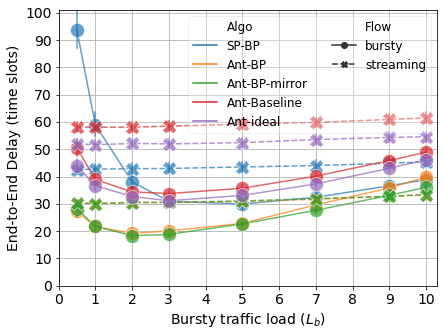

In [519]:
fig, axs = plt.subplots(1, 1, figsize=figsize)
sns.lineplot(
    data=df_f3, x='lb', y="delay_synth", hue='Algo', hue_order = hue_order, style='Flow', 
    style_order=['bursty','streaming'],
    err_style="bars", 
    # errorbar=("sd", 0.1), 
    markers=True, markersize=markersize, ax= axs, legend=True,alpha = 0.7
)
axs.set_xlabel('Bursty traffic load (${L}_{b}$)', fontsize=fontsize)
axs.set_ylabel("End-to-End Delay (time slots)", fontsize=fontsize)
axs.set_xlim(0., 10.3)
axs.set_ylim([0,101])
axs.set_xticks(range(0, 11))
axs.set_yticks(range(0, 101, 10))
axs.grid(True)
axs.tick_params(axis='x', which='both', labelsize=labelsize)  # Adjust label size
#axs.xaxis.label.set_size(14)  # Adjust x-axis label size
axs.tick_params(axis='y', which='both', labelsize=labelsize)  # Adjust label size
ld = axs.legend(
    loc='upper right', 
    # bbox_to_anchor=(0.95, 0.62), 
    fontsize= fontsize-2, ncol=2,
    framealpha=0.3,
)
add_patch(ld, 2)

fig.set_size_inches(figsize)
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(fig_dir,f'Mixed_ErrorbarSynDelayResults_randomprob0.5.pdf'), dpi=300, orientation='portrait')
plt.show()

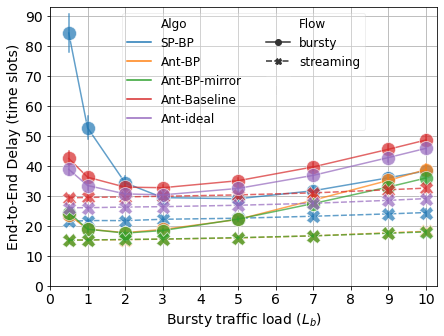

In [520]:
fig, axs = plt.subplots(1, 1, figsize=figsize)
sns.lineplot(
    data=df_f3, x='lb', y="src_delay_raw", hue='Algo', hue_order = hue_order, style='Flow', 
    style_order=['bursty','streaming'],
    err_style="bars", 
    # errorbar=("sd", 0.1), 
    markers=True, markersize=markersize, ax= axs, legend=True,alpha = 0.7
)
axs.set_xlabel('Bursty traffic load (${L}_{b}$)', fontsize=fontsize)
axs.set_ylabel("End-to-End Delay (time slots)", fontsize=fontsize)
axs.set_xlim(0, 10.3)
axs.set_ylim([0,93])
axs.set_xticks(range(0, 11))
axs.set_yticks(range(0, 91, 10))
axs.grid(True)
axs.tick_params(axis='x', which='both', labelsize=labelsize)  # Adjust label size
#axs.xaxis.label.set_size(14)  # Adjust x-axis label size
axs.tick_params(axis='y', which='both', labelsize=labelsize)  # Adjust label size
ld = axs.legend(
    loc='upper center', 
    # bbox_to_anchor=(0.95, 0.62), 
    fontsize= fontsize-2, ncol=2,
    framealpha=0.3,
)
add_patch(ld, 2)

fig.set_size_inches(figsize)
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(fig_dir,f'Mixed_ErrorbarDelayResults_randomprob0.5.pdf'), dpi=300, orientation='portrait')
plt.show()

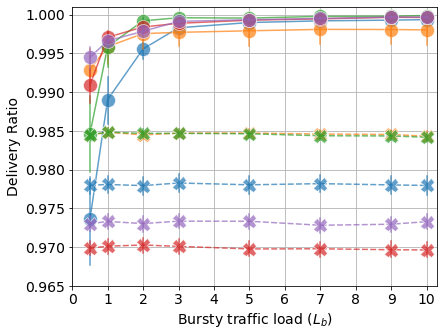

In [521]:
fig, axs = plt.subplots(1, 1, figsize=figsize)
sns.lineplot(
    data=df_f3, x='lb', y="delivery_raw", hue='Algo', hue_order = hue_order, style='Flow', 
    style_order=['bursty','streaming'],
    err_style="bars", 
    # errorbar=("sd", 0.1), 
    markers=True, markersize=markersize, ax= axs, legend=False,alpha = 0.7
)
axs.set_xlabel('Bursty traffic load (${L}_{b}$)', fontsize=fontsize)
axs.set_ylabel("Delivery Ratio", fontsize=fontsize)
axs.set_xlim(0, 10.3)
axs.set_ylim(0.965, 1.001)
axs.set_xticks(range(0, 11))
axs.grid(True)
axs.tick_params(axis='x', which='both', labelsize=labelsize)  # Adjust label size
#axs.xaxis.label.set_size(14)  # Adjust x-axis label size
axs.tick_params(axis='y', which='both', labelsize=labelsize)  # Adjust label size
# axs.legend(
#     loc='lower right', 
#     # bbox_to_anchor=(0.95, 0.62), 
#     fontsize= fontsize-2, ncol=2,
#     framealpha=0.3,
# )

fig.set_size_inches(figsize)
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(fig_dir,f'Mixed_ErrorbarDeliveryResults_randomprob{burstiness_prob}.pdf'), dpi=300, orientation='portrait')
plt.show()

## Robustness test

In [299]:
# Move files from suspicious test results
pburst = 0.5

for opt in [3, 4]:
    for test_set in test_sets:
        ls, lb, robust = test_set
        TV = 500        
        csvfile = 'test_data_poisson_10_ir_0.0_opts_{}_link_26.0_pb_{}_ls_{:.1f}_lb_{:.1f}_robust_{}_T_1000_TV_{}.csv'.format(
            opt, pburst, ls, lb, robust, TV
        )
        csvfull = os.path.join(output_dir, csvfile)
        if not os.path.isfile(csvfull):
            print("skip: {}".format(csvfull))
            continue
        print(csvfull)
        newfull = os.path.join(
            output_dir, 
            'test_data_poisson_10_ir_0.0_opts_{}_link_26.0_pb_{}_ls_{:.1f}_lb_{:.1f}_robust_{}_T_1000_TV_{}_backup.csv'.format(
            opt, pburst, ls, lb, robust, TV
            )
        )
        if os.path.isfile(newfull):
            print("Already exist: {}".format(newfull))
        else:
            print("renamed as {}".format(newfull))
            os.rename(csvfull, newfull)


skip: ../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.5_ls_1.0_lb_1.0_robust_False_T_1000_TV_500.csv
skip: ../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.5_ls_1.0_lb_10.0_robust_False_T_1000_TV_500.csv
../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.5_ls_0.5_lb_0.5_robust_True_T_1000_TV_500.csv
Already exist: ../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.5_ls_0.5_lb_0.5_robust_True_T_1000_TV_500_backup.csv
../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.5_ls_0.5_lb_5.0_robust_True_T_1000_TV_500.csv
Already exist: ../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.5_ls_0.5_lb_5.0_robust_True_T_1000_TV_500_backup.csv
../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.5_ls_2.0_lb_2.0_robust_True_T_1000_TV_500.csv
Already exist: ../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.5_ls_2.0_lb_2.0_robust_True_T_1000_TV_500_backup.csv
../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.5_ls_2.0_lb_20.0_robust_True_T_1000_TV

### Load data for this test

In [522]:
fig_dir = '../fig/'
output_dir = '../out'
datapath = '../data/data_poisson_10'
T=1000
TV=1000
cf_radius = 0.0
pburst = 0.5
link_rate_max = 42  # 42
link_rate_min = 10  # 10
link_rate_avg = (link_rate_max + link_rate_min)/2

test_sets = [
    (1.0, 1.0, False),
    (1.0, 10.0, False),
    (0.5, 0.5, True),
    (0.5, 5.0, True),
    (2.0, 2.0, True),
    (2.0, 20.0, True),
]

df_rb = pd.DataFrame([])
for opt in [1,3,4,6,5]:
    if opt==5:
        htxt = 'h_sum_'
    else:
        htxt = ''

    for test_set in test_sets:
        ls, lb, robust = test_set
        if robust :
            TV = 500
        else:
            TV = 1000
        csvfile = 'test_data_poisson_10_ir_0.0_opts_{}_{}link_26.0_pb_{}_ls_{:.1f}_lb_{:.1f}_robust_{}_T_1000_TV_{}.csv'.format(
            opt, htxt, pburst, ls, lb, robust, TV
        )
        csvfull = os.path.join(output_dir, csvfile)
        if not os.path.isfile(csvfull):
            print("skip: {}".format(csvfull))
            continue
        print(csvfull)
        df_tmp = pd.read_csv(csvfull, index_col=False)
        df_tmp['lb'] = lb
        df_tmp['ls'] = ls
        df_rb = pd.concat([df_rb, df_tmp], ignore_index=True)
#     df_res.to_csv(output_csv, index=False)

print(df_rb.shape)
df_rb['delay_synth'] = df_rb['delivery_raw']*df_rb['src_delay_raw'] + (1- df_rb['delivery_raw'])*1000#df_res['T']
# def_res.rename(columns={'lb': 'X', 'b': 'Y'}) 
condition = ((df_rb['cutoff'] == -1) & (df_rb['physical'] == 1))
df_rb.loc[condition, 'Flow'] = 'streaming'
condition = ((df_rb['cutoff'] == 30) & (df_rb['physical'] == 1))
df_rb.loc[condition, 'Flow'] = 'bursty'
df_rb['SB-info'] = df_rb.apply(lambda row: f"({row['ls']}, {row['lb']})", axis=1)

selected = df_rb.loc[df_rb['physical']==1,:].sort_values(by='ls')
selected.shape

../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_1.0_lb_1.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_1.0_lb_10.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_0.5_lb_0.5_robust_True_T_1000_TV_500.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_0.5_lb_5.0_robust_True_T_1000_TV_500.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_2.0_lb_2.0_robust_True_T_1000_TV_500.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.5_ls_2.0_lb_20.0_robust_True_T_1000_TV_500.csv
../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.5_ls_1.0_lb_1.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.5_ls_1.0_lb_10.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.5_ls_0.5_lb_0.5_robust_True_T_1000_TV_500.csv
../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.5_ls_

(117570, 35)

In [535]:
selected.to_csv(
    os.path.join(fig_dir, 'data_mixed_traffic_robustness_pburst0.5.csv'),
    index=False
)

In [523]:
selected.groupby(["Algo", "opt", "SB-info"]).count()

filename  seed  num_nodes     m     T  \
Algo          opt SB-info                                              
Ant-BP        0   (0.5, 0.5)       3919  3919       3919  3919  3919   
                  (0.5, 5.0)       3919  3919       3919  3919  3919   
                  (1.0, 1.0)       3919  3919       3919  3919  3919   
                  (1.0, 10.0)      3919  3919       3919  3919  3919   
                  (2.0, 2.0)       3919  3919       3919  3919  3919   
                  (2.0, 20.0)      3919  3919       3919  3919  3919   
Ant-BP-mirror 0   (0.5, 0.5)       3919  3919       3919  3919  3919   
                  (0.5, 5.0)       3919  3919       3919  3919  3919   
                  (1.0, 1.0)       3919  3919       3919  3919  3919   
                  (1.0, 10.0)      3919  3919       3919  3919  3919   
                  (2.0, 2.0)       3919  3919       3919  3919  3919   
                  (2.0, 20.0)      3919  3919       3919  3919  3919   
Ant-Baseline  0   (0.5, 0.5)       3919  3919       3919  3919  3919   
                  (0.5, 5.0)       3919  3919       3919  3919  3919   
                  (1.0, 1.0)       3919  3919       3919  3919  3919   
                  (1.0, 10.0)      3919  3919       3919  3919  3919   
                  (2.0, 2.0)       3919  3919       3919  3919  3919   
                  (2.0, 20.0)      3919  3919       3919  3919  3919   
Ant-ideal     0   (0.5, 0.5)       3919  3919       3919  3919  3919   
                  (0.5, 5.0)       3919  3919       3919  3919  3919   
                  (1.0, 1.0)       3919  3919       3919  3919  3919   
                  (1.0, 10.0)      3919  3919       3919  3919  3919   
                  (2.0, 2.0)       3919  3919       3919  3919  3919   
                  (2.0, 20.0)      3919  3919       3919  3919  3919   
SP-BP         49  (0.5, 0.5)       3919  3919       3919  3919  3919   
                  (0.5, 5.0)       3919  3919       3919  3919  3919   
                  (1.0, 1.0)       3919  3919       3919  3919  3919   
                  (1.0, 10.0)      3919  3919       3919  3919  3919   
                  (2.0, 2.0)       3919  3919       3919  3919  3919   
                  (2.0, 20.0)      3919  3919       3919  3919  3919   

                               cf_radius  cf_degree  f_case  num_flows  \
Algo          opt SB-info                                                
Ant-BP        0   (0.5, 0.5)        3919       3919    3919       3919   
                  (0.5, 5.0)        3919       3919    3919       3919   
                  (1.0, 1.0)        3919       3919    3919       3919   
                  (1.0, 10.0)       3919       3919    3919       3919   
                  (2.0, 2.0)        3919       3919    3919       3919   
                  (2.0, 20.0)       3919       3919    3919       3919   
Ant-BP-mirror 0   (0.5, 0.5)        3919       3919    3919       3919   
                  (0.5, 5.0)        3919       3919    3919       3919   
                  (1.0, 1.0)        3919       3919    3919       3919   
                  (1.0, 10.0)       3919       3919    3919       3919   
                  (2.0, 2.0)        3919       3919    3919       3919   
                  (2.0, 20.0)       3919       3919    3919       3919   
Ant-Baseline  0   (0.5, 0.5)        3919       3919    3919       3919   
                  (0.5, 5.0)        3919       3919    3919       3919   
                  (1.0, 1.0)        3919       3919    3919       3919   
                  (1.0, 10.0)       3919       3919    3919       3919   
                  (2.0, 2.0)        3919       3919    3919       3919   
                  (2.0, 20.0)       3919       3919    3919       3919   
Ant-ideal     0   (0.5, 0.5)        3919       3919    3919       3919   
                  (0.5, 5.0)        3919       3919    3919       3919   
                  (1.0, 1.0)        3919       3919    3919       3919   
                  (1.0, 

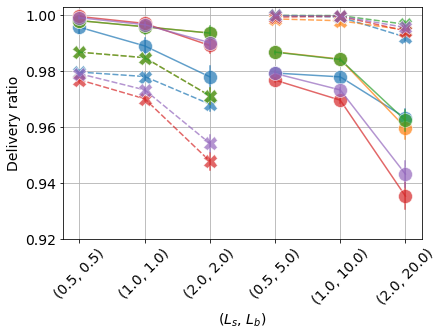

In [524]:
# hue_order = ['SP-BP', 'Ant-BP', 'Ant-Baseline', 'AntHocNet-SP', 'Ant-BP-mirror']

burstiness_prob = 0.5


selected1 = selected[selected['SB-info'].isin(["(0.5, 0.5)", "(1.0, 1.0)", "(2.0, 2.0)"]) ]
selected2 = selected[selected['SB-info'].isin(["(0.5, 5.0)", "(1.0, 10.0)", "(2.0, 20.0)"])]

fig, axs = plt.subplots(1, 1, figsize=figsize)
sns.lineplot(
    data=selected1, x='SB-info', y="delivery_raw", hue='Algo', hue_order = hue_order, style='Flow', 
    style_order=['bursty','streaming'],
    err_style="bars", 
    # errorbar=("sd", 0.1), 
    markers=True, markersize=markersize, legend=False, ax= axs,alpha = 0.7
)
sns.lineplot(
    data=selected2, x='SB-info', y="delivery_raw", hue='Algo', hue_order = hue_order, style='Flow', 
    err_style="bars", 
    # errorbar=("sd", 0.1), 
    markers=True, markersize=markersize, legend=False, ax= axs,alpha = 0.7
)

axs.grid(True)
axs.tick_params(axis='x', which='both', labelsize=labelsize, labelrotation=45)  # Adjust label size
axs.tick_params(axis='y', which='both', labelsize=labelsize)  # Adjust label size
#axs.tick_params(axis='x', which='both', labelrotation=2)
axs.set_ylim(0.92, 1.003)
axs.set_xlabel('(${L}_{s}$, ${L}_{b}$)', fontsize=fontsize)
axs.set_ylabel("Delivery ratio", fontsize=fontsize)

fig.set_size_inches(figsize)
plt.tight_layout(pad=0.1)
#         plt.savefig(os.path.join(output_dir,f'Robusttestmatchingdelivery_ErrorbarResults_randomprob{burstiness_prob}.png'))
plt.savefig(os.path.join(fig_dir,f'Robusttestmatchingdelivery_ErrorbarResults_randomprob{burstiness_prob}.pdf'), dpi=300, orientation='portrait')
plt.show()


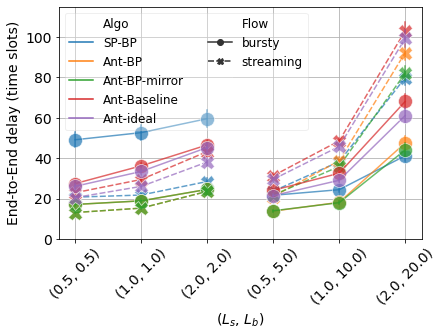

In [525]:
fig, axs = plt.subplots(1, 1, figsize=figsize)
sns.lineplot(
    data=selected1, x='SB-info', y="src_delay_raw", hue='Algo', hue_order = hue_order, style='Flow', 
    style_order=['bursty','streaming'],
    err_style="bars", 
    # errorbar=("sd", 0.1), 
    markers=True, markersize=markersize, ax= axs, alpha = 0.7
)
sns.lineplot(
    data=selected2, x='SB-info', y="src_delay_raw", hue='Algo', hue_order = hue_order, style='Flow', 
    err_style="bars", 
    # errorbar=("sd", 0.1), 
    markers=True, markersize=markersize, ax= axs, alpha = 0.7, legend=False
)
axs.set_ylim([0,115])
axs.grid(True)
ld = axs.legend(loc='upper left',  fontsize= fontsize-2, framealpha=0.3, ncol=2) #bbox_to_anchor=(0.28, 0.28),
add_patch(ld, 2)
axs.tick_params(axis='x', which='both', labelsize=labelsize, labelrotation=45)  # Adjust label size
axs.tick_params(axis='y', which='both', labelsize=labelsize)  # Adjust label size
axs.set_xlabel('(${L}_{s}$, ${L}_{b}$)', fontsize=fontsize)
axs.set_ylabel("End-to-End delay (time slots)", fontsize=fontsize)
fig.set_size_inches(figsize)
plt.tight_layout(pad=0.1)
#         plt.savefig(os.path.join(output_dir,f'Robusttestmatchingdelay_ErrorbarResults_randomprob{burstiness_prob}.png'))
plt.savefig(os.path.join(fig_dir,f'Robusttestmatchingdelay_ErrorbarResults_randomprob{burstiness_prob}.pdf'), dpi=300, orientation='portrait')
plt.show()


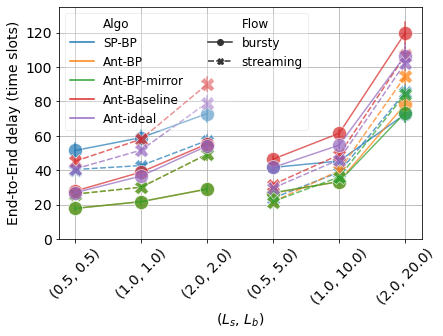

In [526]:


fig, axs = plt.subplots(1, 1, figsize=figsize)
sns.lineplot(
    data=selected1, x='SB-info', y="delay_synth", hue='Algo', hue_order = hue_order, style='Flow', 
    style_order=['bursty','streaming'],
    err_style="bars",
    # errorbar=("sd", 0.1), 
    markers=True, markersize=markersize, ax= axs, legend=True,alpha = 0.7
)
sns.lineplot(
    data=selected2, x='SB-info', y="delay_synth", hue='Algo', hue_order = hue_order, style='Flow', 
    err_style="bars", 
    # errorbar=("sd", 0.1), 
    markers=True, markersize=markersize, ax= axs, legend=False,alpha = 0.7
)
axs.set_xlabel('(${L}_{s}$, ${L}_{b}$)', fontsize=fontsize)
axs.set_ylabel("End-to-End delay (time slots)", fontsize=fontsize)
axs.set_ylim([0,135])
ld = axs.legend(loc='upper left',  fontsize= fontsize-2, framealpha=0.3, ncol=2) #bbox_to_anchor=(0.28, 0.28),   
add_patch(ld, 2)
axs.grid(True)
axs.tick_params(axis='x', which='both', labelsize=labelsize, labelrotation=45)  # Adjust label size
axs.tick_params(axis='y', which='both', labelsize=labelsize)  # Adjust label size


fig.set_size_inches(figsize)
plt.tight_layout(pad=0.1)
#         plt.savefig(os.path.join(output_dir,f'Robusttestmatchingsyndelay_ErrorbarResults_randomprob{burstiness_prob}.png'), orientation='portrait')
plt.savefig(os.path.join(fig_dir,f'Robusttestmatchingsyndelay_ErrorbarResults_randomprob{burstiness_prob}.pdf'), dpi=300)
plt.show()


## Fig 6, throughput optimality test

In [266]:
T=1000
TV=1000
cf_radius = 0.0
pburst = 0.0
link_rate_max = 42  # 42
link_rate_min = 10  # 10
link_rate_avg = (link_rate_max + link_rate_min)/2
lb=1.0

for opt in [3]:
    for ls in [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11., 12.]:
        csvfile = 'test_data_poisson_10_ir_0.0_opts_{}_link_26.0_pb_{}_ls_{:.1f}_lb_{:.1f}_robust_False_T_1000_TV_{}.csv'.format(
            opt, pburst, ls, lb, TV
        )
        csvfull = os.path.join(output_dir, csvfile)
        if not os.path.isfile(csvfull):
            print("skip: {}".format(csvfull))
            continue
        print(csvfull)
        newfull = os.path.join(
            output_dir, 
            'test_data_poisson_10_ir_0.0_opts_{}_link_26.0_pb_{}_ls_{:.1f}_lb_{:.1f}_robust_{}_T_1000_TV_{}.csv'.format(
            opt, pburst, ls, lb, robust, 500
            )
        )
        if os.path.isfile(newfull):
            print("Already exist: {}".format(newfull))
        else:
            print("renamed as {}".format(newfull))
            os.rename(csvfull, newfull)

../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.0_ls_3.0_lb_1.0_robust_False_T_1000_TV_1000.csv
renamed as ../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.0_ls_3.0_lb_1.0_robust_True_T_1000_TV_500.csv
../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.0_ls_4.0_lb_1.0_robust_False_T_1000_TV_1000.csv
renamed as ../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.0_ls_4.0_lb_1.0_robust_True_T_1000_TV_500.csv
../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.0_ls_5.0_lb_1.0_robust_False_T_1000_TV_1000.csv
renamed as ../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.0_ls_5.0_lb_1.0_robust_True_T_1000_TV_500.csv
../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.0_ls_6.0_lb_1.0_robust_False_T_1000_TV_1000.csv
renamed as ../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.0_ls_6.0_lb_1.0_robust_True_T_1000_TV_500.csv
../out/test_data_poisson_10_ir_0.0_opts_3_link_26.0_pb_0.0_ls_7.0_lb_1.0_robust_False_T_1000_TV_1000.csv
renamed as ../out/t

In [537]:
fig_dir = '../fig/'
output_dir = '../out'
datapath = '../data/data_poisson_10'
T=1000
TV=1000
cf_radius = 0.0
pburst = 0.0
link_rate_max = 42  # 42
link_rate_min = 10  # 10
link_rate_avg = (link_rate_max + link_rate_min)/2
lb=1.0

df_f6 = pd.DataFrame([])
for opt in [1,3,5,6]:
    for ls in [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11., 12.]:
        if opt==5:
            htxt = 'h_sum_'
        else:
            htxt = ''
        csvfile = 'test_data_poisson_10_ir_0.0_opts_{}_{}link_26.0_pb_{}_ls_{:.1f}_lb_{:.1f}_robust_False_T_1000_TV_{}.csv'.format(
            opt, htxt, pburst, ls, lb, TV
        )
        csvfull = os.path.join(output_dir, csvfile)
        if not os.path.isfile(csvfull):
            print("skip: {}".format(csvfull))
            continue
        print(csvfull)
        df_tmp = pd.read_csv(csvfull, index_col=False)
        df_tmp['lb'] = lb
        df_tmp['ls'] = ls
        df_f6 = pd.concat([df_f6, df_tmp], ignore_index=True)
#     df_res.to_csv(output_csv, index=False)

df_f6['delay_synth'] = df_f6['delivery_raw']*df_f6['src_delay_raw'] + (1- df_f6['delivery_raw'])*1000#df_res['T']

df_f6 = df_f6.loc[df_f6['physical']==1,:]
condition = ((df_f6['cutoff'] == -1) & (df_f6['physical'] == 1))
df_f6.loc[condition, 'Flow'] = 'streaming'
condition = ((df_f6['cutoff'] == 30) & (df_f6['physical'] == 1))
df_f6.loc[condition, 'Flow'] = 'bursty'
df_f6.shape

../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.0_ls_0.5_lb_1.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.0_ls_1.0_lb_1.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.0_ls_2.0_lb_1.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.0_ls_3.0_lb_1.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.0_ls_4.0_lb_1.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.0_ls_5.0_lb_1.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.0_ls_6.0_lb_1.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.0_ls_7.0_lb_1.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_0.0_ls_8.0_lb_1.0_robust_False_T_1000_TV_1000.csv
../out/test_data_poisson_10_ir_0.0_opts_1_link_26.0_pb_

(197738, 34)

In [536]:
df_f6.to_csv(
    os.path.join(fig_dir, 'data_streaming_traffic_throughput.csv'),
    index=False
)

In [538]:
df_gp_avg = df_f6.groupby(["filename", "f_case", "Algo", "ls"]).mean().reset_index()
df_gp_sum = df_f6.groupby(["filename", "f_case", "Algo", "ls"]).sum().reset_index()
df_gp_sum_reduced = df_gp_sum[["filename", "f_case", "Algo", "ls", "cnt_out_raw", "cnt_in_raw"]]

merged_df = pd.merge(df_gp_avg, df_gp_sum_reduced, on=["filename", "f_case", "Algo", "ls"], suffixes=('', '_sum'))
merged_df

,filename,f_case,Algo,ls,seed,num_nodes,m,T,cf_radius,cf_degree,...,src_jitter_raw,delivery_raw,active_links,cnt_out_raw,cnt_in_raw,runtime,lb,delay_synth,cnt_out_raw_sum,cnt_in_raw_sum
0,poisson_graph_seed500_m8_n100_f17.mat,0,Ant-BP,0.5,500.0,100.0,8.0,1000.0,0.0,13.366154,...,52.585732,0.987266,51.778,313.875000,317.468750,85.698447,1.0,23.078993,10044,10159
1,poisson_graph_seed500_m8_n100_f17.mat,0,Ant-BP,1.0,500.0,100.0,8.0,1000.0,0.0,13.366154,...,111.511372,0.987448,78.808,626.875000,634.437500,116.229360,1.0,24.513613,20060,20302
2,poisson_graph_seed500_m8_n100_f17.mat,0,Ant-BP,2.0,500.0,100.0,8.0,1000.0,0.0,13.366154,...,454.866273,0.984307,125.619,1261.906250,1280.156250,157.602448,1.0,31.022715,40381,40965
3,poisson_graph_seed500_m8_n100_f17.mat,0,Ant-BP,3.0,500.0,100.0,8.0,1000.0,0.0,13.366154,...,352.512850,0.980727,154.151,1890.406250,1925.593750,308.781371,1.0,37.357682,60493,61619
4,poisson_graph_seed500_m8_n100_f17.mat,0,Ant-BP,4.0,500.0,100.0,8.0,1000.0,0.0,13.366154,...,1042.327736,0.951934,188.517,2439.375000,2561.312500,322.590312,1.0,80.389684,78060,81962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5044,poisson_graph_seed517_m8_n100_f24.mat,9,SP-BP,8.0,517.0,100.0,8.0,1000.0,0.0,12.689655,...,20997.259879,0.466448,317.824,2192.645833,4528.250000,126.622008,1.0,581.355806,105247,217356
5045,poisson_graph_seed517_m8_n100_f24.mat,9,SP-BP,9.0,517.0,100.0,8.0,1000.0,0.0,12.689655,...,20168.151902,0.423315,318.013,2241.791667,5091.729167,122.599606,1.0,602.136245,107606,244403
5046,poisson_graph_seed517_m8_n100_f24.mat,9,SP-BP,10.0,517.0,100.0,8.0,1000.0,0.0,12.689655,...,24176.427167,0.380114,318.208,2251.729167,5665.979167,126.907036,1.0,641.736100,108083,271967
5047,poisson_graph_seed517_m8_n100_f24.mat,9,SP-BP,11.0,517.0,100.0,8.0,1000.0,0.0,12.689655,...,24460.302833,0.344594,318.327,2256.020833,6231.729167,131.284026,1.0,667.376712,108289,299123


In [539]:
merged_df['throughput'] = merged_df["cnt_out_raw_sum"]/merged_df['T']
# def_res.rename(columns={'lb': 'X', 'b': 'Y'}) 

hue_order_sel = ['SP-BP', 'Ant-BP', None, 'Ant-Baseline', 'Ant-ideal']


<ipython-input-555-0e0b93220af6>:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1)


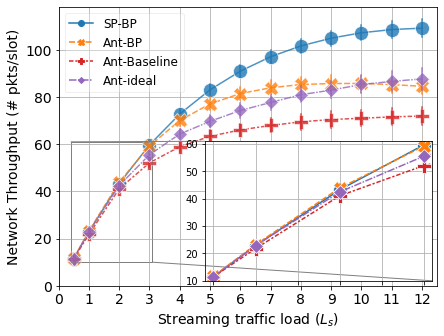

In [555]:
fig, axs = plt.subplots(1, 1, figsize=figsize)
sns.lineplot(
    data=merged_df, x='ls', y="throughput", hue='Algo', hue_order = hue_order_sel, 
    style='Algo', style_order=hue_order_sel,
    err_style="bars", 
    # errorbar=("sd", 0.1), 
    markers=True, markersize=markersize, ax= axs, legend=True,alpha = 0.8
)
axs.set_xlabel('Streaming traffic load (${L}_{s}$)', fontsize=fontsize)
axs.set_ylabel("Network Throughput (# pkts/slot)", fontsize=fontsize)
axs.set_xticks(range(0, 13))
axs.set_xlim(0, 12.5)
axs.set_ylim([0,None])
axs.grid(True)
axs.tick_params(axis='x', which='both', labelsize=labelsize)  # Adjust label size
#axs.xaxis.label.set_size(14)  # Adjust x-axis label size
axs.tick_params(axis='y', which='both', labelsize=labelsize)  # Adjust label size
ld = axs.legend(
    loc='best',#'lower right', 
    # bbox_to_anchor=(0.95, 0.62), 
    fontsize= fontsize-2, 
#     ncol=2,
    framealpha=0.3,
)
# add_patch(ld, 2)

# Create an inset axis
ax_inset = inset_axes(axs, width="60%", height="50%", loc="lower right")

x1, x2 = 0.4, 3.1
y1, y2 = 10, 61
# Plot the zoomed-in area
sns.lineplot(
    data=merged_df, x='ls', y="throughput", hue='Algo', hue_order = hue_order_sel, 
    style='Algo', style_order=hue_order_sel,
    err_style="bars", 
    # errorbar=("sd", 0.1), 
    markers=True, markersize=markersize, 
    ax=ax_inset, legend=False, 
#     alpha = 0.7
)

ax_inset.set_xlim(x1, x2)
ax_inset.set_ylim(y1, y2)
ax_inset.set_xticklabels([])
# ax_inset.set_yticklabels([])
ax_inset.set_xlabel('')
ax_inset.set_ylabel('')
ax_inset.grid(True)

# Optionally, add a rectangle on the main plot to indicate the zoomed-in area
axs.indicate_inset_zoom(ax_inset)

# Mark the zoomed area
mark_inset(axs, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")


fig.set_size_inches(figsize)
plt.tight_layout(pad=0.1)
#         plt.savefig(os.path.join(output_dir,f'Mixed_ErrorbarSynDelayResults_randomprob{burstiness_prob}.png'), orientation='portrait') #, dpi=300
plt.savefig(os.path.join(fig_dir,f'Streamingoptimalitydelivery_Results.pdf'), dpi=300, orientation='portrait')
plt.show()

In [541]:
nx.__version__

'2.8.6'

In [542]:
# condition = (merged_df["Algo"]=="Ant-Baseline") & (merged_df["ls"] <= 2.0)
# condition = (merged_df["ls"] <= 2.0)
df_ck = merged_df
df_ck.groupby(["Algo", "ls"]).count()

filename  f_case  seed  num_nodes    m    T  cf_radius  \
Algo         ls                                                             
Ant-BP       0.5        100     100   100        100  100  100        100   
             1.0        100     100   100        100  100  100        100   
             2.0        100     100   100        100  100  100        100   
             3.0        100     100   100        100  100  100        100   
             4.0        100     100   100        100  100  100        100   
             5.0        100     100   100        100  100  100        100   
             6.0        100     100   100        100  100  100        100   
             7.0        100     100   100        100  100  100        100   
             8.0        100     100   100        100  100  100        100   
             9.0        100     100   100        100  100  100        100   
             10.0       100     100   100        100  100  100        100   
             11.0       100     100   100        100  100  100        100   
             12.0       100     100   100        100  100  100        100   
Ant-Baseline 0.5        100     100   100        100  100  100        100   
             1.0        100     100   100        100  100  100        100   
             2.0        100     100   100        100  100  100        100   
             3.0        100     100   100        100  100  100        100   
             4.0        100     100   100        100  100  100        100   
             5.0        100     100   100        100  100  100        100   
             6.0        100     100   100        100  100  100        100   
             7.0        100     100   100        100  100  100        100   
             8.0        100     100   100        100  100  100        100   
             9.0        100     100   100        100  100  100        100   
             10.0       100     100   100        100  100  100        100   
             11.0       100     100   100        100  100  100        100   
             12.0       100     100   100        100  100  100        100   
Ant-ideal    0.5        100     100   100        100  100  100        100   
             1.0        100     100   100        100  100  100        100   
             2.0        100     100   100        100  100  100        100   
             3.0         99      99    99         99   99   99         99   
             4.0         95      95    95         95   95   95         95   
             5.0         87      87    87         87   87   87         87   
             6.0         85      85    85         85   85   85         85   
             7.0         82      82    82         82   82   82         82   
             8.0         83      83    83         83   83   83         83   
             9.0         81      81    81         81   81   81         81   
             10.0        79      79    79         79   79   79         79   
             11.0        78      78    78         78   78   78         78   
             12.0        80      80    80         80   80   80         80   
SP-BP        0.5        100     100   100        100  100  100        100   
             1.0        100     100   100        100  100  100        100   
             2.0        100     100   100        100  100  100        100   
             3.0        100     100   100        100  100  100        100   
             4.0        100     100   100        100  100  100        100   
             5.0        100     100   100        100  100  100        100   
             6.0        100     100   100        100  100  100        100   
             7.0        100     100   100        100  100  100        100   
             8.0        100     100   100        100  100  100        100   
             9.0        100     100   100        100  100  100        100   
             10.0       100     100   100        100  100  100        100   
             11

In [337]:
merged_df["Algo"].unique()

array(['Ant-BP', 'Ant-Baseline', 'Ant-ideal', 'SP-BP'], dtype=object)